In [0]:
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import matplotlib.image as img
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
from random import randint
import tensorflow.keras.models as Models
import tensorflow.keras.layers as Layers
import tensorflow.keras.optimizers as Optimizer
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot



import keras
import tensorflow.keras.activations as Actications
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
import matplotlib.gridspec as gridspec

Using TensorFlow backend.


## Preprocesado y limpieza de Datos
Una vez descargadas las imagenes indicadas en la consigna Trabajo Practico [[aquí](https://www.kaggle.com/rhammell/ships-in-satellite-imagery)], se presenta a continuacion la transformacion de esas imagenes a datos posibles de trabajar.

In [0]:
data=[]
labels=[]
images = os.listdir('imagenes_tp3_cv/')

%time
for i in images:
    try:
        image = cv2.imread('imagenes_tp3_cv/'+i)
        image_to_array=Image.fromarray(image,"RGB")
        size_image=image_to_array.resize((80,80))
        data.append(np.array(size_image))
        if i.startswith( '1' ):
            labels.append(1)
        else: 
            labels.append(0)
    except AttributeError:
        print("")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs



Para simplificar futuras funciones, generamos una lista **CLASSIFFICATION** donde se encuentran los posibles valores de salida, es decir **Barco o No Barco**

In [0]:
CLASSIFICATION=[]
CLASSIFICATION.append('No Barco')
CLASSIFICATION.append('Barco')

CLASSIFICATION

['No Barco', 'Barco']

In [0]:
input_data = np.array(data)
output_data = np.array(labels)

In [0]:
input_data.shape

(4000, 80, 80, 3)

In [0]:
train_input, test_validation_input, train_output, test_validation_output= train_test_split(input_data, output_data, test_size=0.2)
validation_input, test_input, validation_output, test_output = train_test_split(test_validation_input,test_validation_output, test_size=0.6)
sets = (
    ('train', (train_input,train_output)),
    ('test', (test_input, test_output)),
    ('validation', (validation_input, validation_output))
)

for set_name, set_data in sets:
    print("Imagenes del set", set_name)
    print("Dimensión de {setname}: {dim}".format(
        setname=set_name,
        dim=(set_data[0].shape,set_data[1].shape)
    ))

Imagenes del set train
Dimensión de train: ((3200, 80, 80, 3), (3200,))
Imagenes del set test
Dimensión de test: ((480, 80, 80, 3), (480,))
Imagenes del set validation
Dimensión de validation: ((320, 80, 80, 3), (320,))


## Aserca de las fotos con las que vamos a trabajar
Se presentan conjunto de fotos random, etiquetadas, del conjunto a estudiar

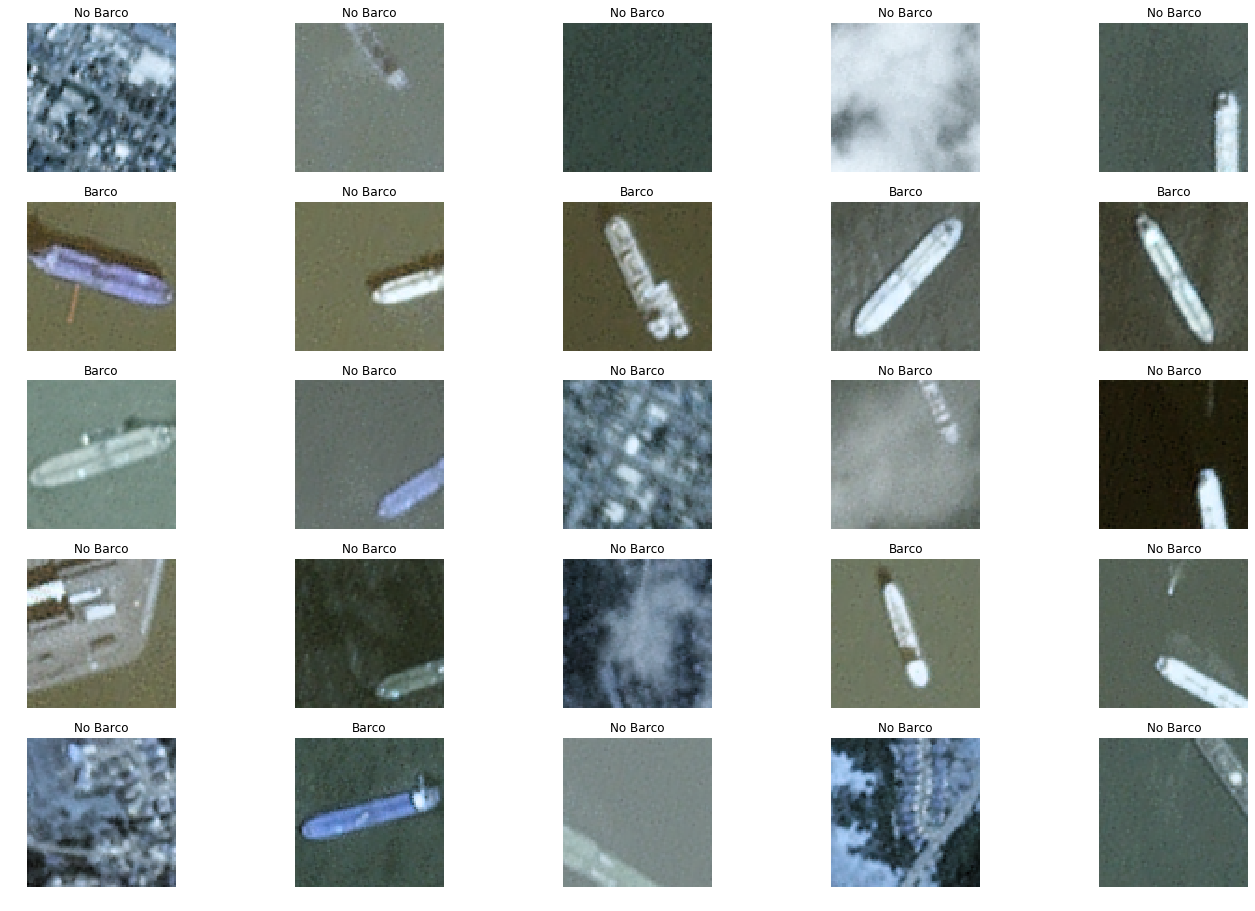

In [0]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(input_data))
        ax[i,j].imshow(input_data[rnd_number])
        ax[i,j].set_title('Barco' if output_data[rnd_number] else 'No Barco')
        ax[i,j].axis('off')
        


El siguiente **Histograma** respresenta los **Píxeles por pulgada (PPP)**, la cual es una medida de densidad de píxeles que relaciona el número total de pixeles de la imagen con su tamaño en pulgadas, en la dirección horizontal y en la dirección vertical. 

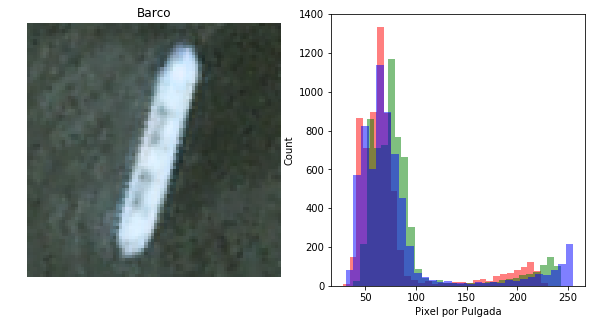

In [0]:
shipFound = 0
while shipFound == 0:
    rnd_number = randint(0,len(input_data))
    if output_data[rnd_number] == 1:
        barco = rnd_number 
        shipFound = 1
        
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('Barco' if output_data[barco] else 'No Barco')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel por Pulgada')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(input_data[barco])

## CNN - Convolutional neural network

In [0]:
model = Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 78, 78, 200)       5600      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 76, 76, 180)       324180    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 180)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 180)       291780    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 140)       226940    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 100)         126100    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 50)          45050     
__________

In [0]:
trained = model.fit(train_input,train_output,epochs=5,validation_data=(test_input,test_output))

Train on 3200 samples, validate on 480 samples
Epoch 1/5
3200/3200 [==============================] - 554s 173ms/sample - loss: 0.7770 - acc: 0.7231 - val_loss: 0.3300 - val_acc: 0.8604
Epoch 2/5
3200/3200 [==============================] - 563s 176ms/sample - loss: 0.4791 - acc: 0.8281 - val_loss: 0.1660 - val_acc: 0.9333
Epoch 3/5
3200/3200 [==============================] - 572s 179ms/sample - loss: 0.3027 - acc: 0.8878 - val_loss: 0.1276 - val_acc: 0.9563
Epoch 4/5
3200/3200 [==============================] - 587s 183ms/sample - loss: 0.2737 - acc: 0.9062 - val_loss: 0.1396 - val_acc: 0.9563
Epoch 5/5
3200/3200 [==============================] - 596s 186ms/sample - loss: 0.2077 - acc: 0.9297 - val_loss: 0.0775 - val_acc: 0.9729


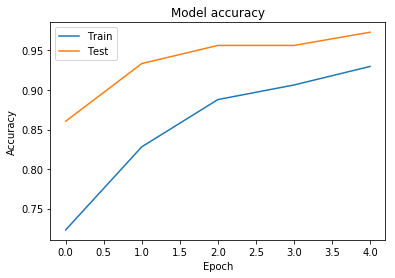

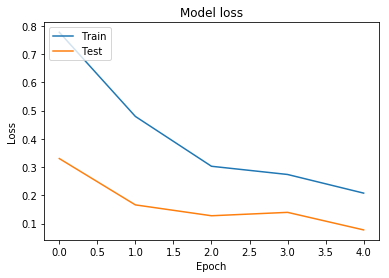

In [0]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [0]:
model.evaluate(validation_input,validation_output, verbose=1)

320/320 [==============================] - 16s 48ms/sample - loss: 0.1831 - acc: 0.9531


[0.1831168971955776, 0.953125]

## Multilayer perceptron 

Como segundo modelo elegimos MLP, aunque no esperamos que pueda mejorar los resultados de la convolución, dado que esta última es conocida por su efectividad en la clasificación de imágenes.

In [0]:
model = Models.Sequential() 
model.add(Layers.Flatten(input_shape=(80, 80, 3)))
model.add(Layers.Dense(9, activation="relu"))
model.add(Layers.Dropout(0.2)) 
model.add(Layers.Dense(3, activation="relu"))
model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(2, activation="softmax"))

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [0]:
trained = model.fit(train_input, train_output,epochs=10,validation_data=(test_input, test_output))

Train on 3200 samples, validate on 480 samples
Epoch 1/10
3200/3200 [==============================] - 1s 186us/sample - loss: 6.8523 - acc: 0.5594 - val_loss: 3.8952 - val_acc: 0.7583
Epoch 2/10
3200/3200 [==============================] - 0s 106us/sample - loss: 5.7938 - acc: 0.6247 - val_loss: 3.8952 - val_acc: 0.7583
Epoch 3/10
3200/3200 [==============================] - 0s 107us/sample - loss: 6.1762 - acc: 0.6006 - val_loss: 3.8952 - val_acc: 0.7583
Epoch 4/10
3200/3200 [==============================] - 0s 99us/sample - loss: 5.8971 - acc: 0.6153 - val_loss: 3.8952 - val_acc: 0.7583
Epoch 5/10
3200/3200 [==============================] - 0s 100us/sample - loss: 5.7479 - acc: 0.6259 - val_loss: 3.8952 - val_acc: 0.7583
Epoch 6/10
3200/3200 [==============================] - 0s 108us/sample - loss: 5.9571 - acc: 0.6119 - val_loss: 3.8952 - val_acc: 0.7583
Epoch 7/10
3200/3200 [==============================] - 0s 97us/sample - loss: 5.7271 - acc: 0.6253 - val_loss: 3.8952 - val_a

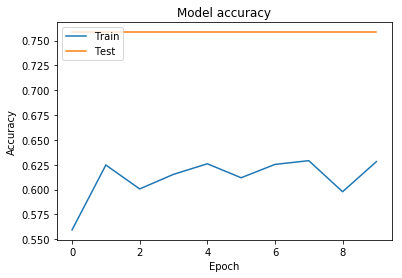

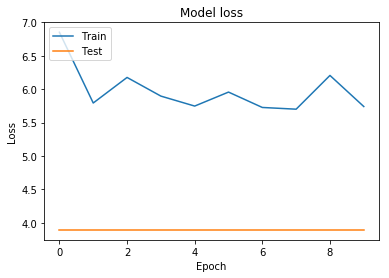

In [0]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [0]:
model.evaluate(validation_input,validation_output, verbose=1)

320/320 [==============================] - 0s 59us/sample - loss: 3.6769 - acc: 0.7719


[3.6769405603408813, 0.771875]

###Conclusiones
Tal como esperabamos, con MLP obtuvimos resultados de accuracy notoriamente peores en comparación con CNN.

Si analizamos las cantidades de neuronas, capas y tiempos de entrenamiento utilizados en ambos modelos, vemos en el MLP son  muchísimo menores. 

Esto nos hace suponer que ese 70% de accuracy se debe a que son casos "fáciles" de clasificar, y que la CNN podría arrojar aún mejores resultados, retocando el modelo: las funciones de activacion y cantidad de neuronas/capas. Esto requiere escencialmente más tiempo para experimentar y tal vez más necesario,  mejor hardware a nuestra disponibilidad.
